# Szegedy’s quantum walk with queries (Santos, 2016)

Implementation of the algorithm described in [this paper](https://link.springer.com/article/10.1007/s11128-016-1427-4).

## Import libraries

In [289]:
import pennylane as qml
import pennylane.numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [158]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3, suppress=True)
qml.__version__

'0.41.1'

## 2 Szegedy's Quatum Walk

In [354]:
N = 5 # dimension of the graph
n = int(np.ceil(np.log2(N))) # dimension of the associated Hilbert space
print(f"N = {N}")
print(f"n = {n}")

N = 5
n = 3


### Stochastic matrices

![Complete graph with m=5, n=1](complete_graph_m1.PNG "Complete graph with m=5, n=1")

#### $P'$

In [392]:
m = 5 # marked state
absorbing = True # absorbing QRW for marked states
# transition matrix
P = block_diag(1/(N-1) * (np.ones(N) - np.eye(N)), np.eye(2**n-N))
# absorbing RW
if (absorbing):
    for i in range(N):
        P[m-1, i] = 0
    P[m-1, m-1] = 1

# print(P)
print(P.shape)
# print(P*P.T)

(8, 8)


#### $R_A$

In [393]:
# initial state of the quantum walk
RA = np.zeros((2**(2*n), 2**(2*n)))

for x in range(2**n):
    phi = np.zeros((2**(2*n), 1))
    ket_x = np.zeros((2**n, 1))
    ket_x[x] = 1
    for y in range(2**n):
        ket_y = np.zeros((2**n, 1))
        ket_y[y] = np.sqrt(P[x][y])
        phi += np.kron(ket_x, ket_y) # x⊗y
    # print(f"x={x}")
    # print(np.sum(phi**2)) # norm-square: should be one for a "valid" quantum state
    # print(phi.T)   
    RA += np.dot(phi, phi.T)    
RA = 2 * RA - np.eye(2**(2*n))
print(RA.shape)
# print(RA)
# print('\n')
# print(np.dot(RA, RA.T))
print(r'Is $R_A$ unitary (left)?', np.all(np.allclose(np.dot(RA, RA.T), np.eye(2**(2*n)))))
# print(np.dot(RA.T, RA))
print(r'Is $R_A$ unitary (right)?', np.all(np.allclose(np.dot(RA.T, RA), np.eye(2**(2*n)))))

(64, 64)
Is $R_A$ unitary (left)? True
Is $R_A$ unitary (right)? True


#### $R_B$

In [394]:
RB = np.zeros((2**(2*n), 2**(2*n)))

for y in range(2**n):
    psi = np.zeros((2**(2*n), 1))
    ket_y = np.zeros((2**n, 1))
    ket_y[y] = 1
    for x in range(2**n):
        ket_x = np.zeros((2**n, 1))
        ket_x[x] = np.sqrt(P[y][x])
        psi += np.kron(ket_x, ket_y) # y⊗x
    RB += np.dot(psi, psi.T)    
RB = 2 * RB - np.eye(2**(2*n))
print(RB.shape)
# print(RB)
# print(np.dot(RB, RB.T))
print('Is RB unitary (left)?', np.all(np.allclose(np.dot(RB, RB.T), np.eye(2**(2*n)))))
print('Is RB unitary (right)?', np.all(np.allclose(np.dot(RB.T, RB), np.eye(2**(2*n)))))

(64, 64)
Is RB unitary (left)? True
Is RB unitary (right)? True


### Searching

In [395]:
# initial state
psi = np.zeros((2**(2*n)))
for x in range(N):
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        ket_y = np.zeros((2**n))
        ket_y[y] += np.sqrt(P[x][y])
        psi += np.kron(ket_x, ket_y)    
psi /= np.sqrt(N)
# print(psi)
print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(psi**2)), 1))

Is the statevector valid? True


In [396]:
Up = np.dot(RB, RA) # marked walk operator

### Quantum circuit

In [410]:
num_qubits = 2*n
# Create a device for simulation
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(steps):
    # qml.StatePrep(psi, wires=range(num_qubits))
    [qml.Hadamard(i) for i in range(num_qubits)]
    # [qml.Hadamard(i) for i in range(N)]
    # [qml.Hadamard(i) for i in range(2**n, N)]
    for _ in range(steps):
        # Apply the unitary matrix
        qml.QubitUnitary(Up, wires=range(num_qubits), id=r"U_p")
    # Measure all qubits
    return qml.state()

# data arrays
m_x = []
m_y = []
max_data = []

# Execute the circuit
print("Steps\tMax\t\t\tmax_index\tx\ty\tx==m")
steps = 3*N
for k in range(1, steps+1):
    state_vector = circuit(k)
    # Plot the quantum circuit
    # fig, ax = qml.draw_mpl(circuit)(steps)
    # ax.set_title(f"k={steps}", fontsize=20)
    max_prob = np.abs(np.max(state_vector))
    max_data.append(max_prob) 
    max_index = qml.math.argmax(state_vector)
    print(f"{k}\t{np.abs(np.max(state_vector))}\t{max_index}\t\t{max_index//2**n}\t{max_index%2**n}\t{max_index//2**n==m-1}")
    if max_index//2**n==m-1:
        m_x.append(k)
        m_y.append(max_prob)
    # print(state_vector)

Steps	Max			max_index	x	y	x==m
1	0.24999999999999994	33		4	1	True
2	0.12499999999999994	0		0	0	False
3	0.20312499999999994	4		0	4	False
4	0.20703124999999994	4		0	4	False
5	0.24853515624999997	33		4	1	True
6	0.1304931640625	33		4	1	True
7	0.12499999999999994	0		0	0	False
8	0.25129699707031244	12		1	4	False
9	0.19909095764160156	33		4	1	True
10	0.21080636978149409	32		4	0	True
11	0.12499999999999994	0		0	0	False
12	0.24690371751785278	12		1	4	False
13	0.13592059910297394	28		3	4	False
14	0.2524250391870737	32		4	0	True
15	0.12499999999999994	0		0	0	False


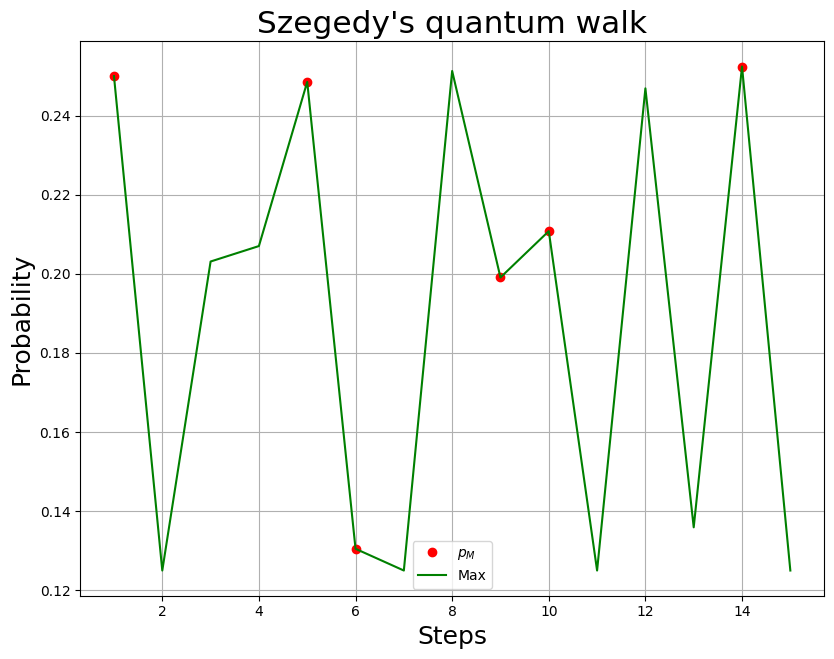

In [417]:
scale_factor = 1.5
default_figsize = plt.rcParams["figure.figsize"]
scaled_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

plt.figure(figsize=scaled_figsize)
plt.plot(m_x, m_y, "ro", label=r"$p_M$")
plt.plot(range(1, steps+1), max_data, 'g', label=r"Max")
plt.legend()
plt.title("Szegedy's quantum walk", fontsize=15*scale_factor)
plt.xlabel("Steps", fontsize=12*scale_factor)
plt.ylabel("Probability", fontsize=12*scale_factor)
plt.grid()
plt.show()

In [383]:
qml.math.argmax(state_vector)

np.int64(25)

In [399]:
m

5